# Solving a simple control problem
### Yabra Muvdi

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m 
import random

## Problem 1: Policy evaluation

### 0. Classes and functions definition

The code below implements the classess required to: 
- model the queue control problem
- implement the TD0 policy evaluation algorithm
- implement the LSTD policy evaluation algorithm

In [87]:
class Queue:
    """ A class to 
    
    Attributes:
        - N: captures the maximum length of the queue
        - state: captures the current state of the queue
        - service_rate: dictionary with the two possible rates of service
        - cost: dictionary with the two possible costs associated to each rate of service
        - arrival_rate
    
    """
    
    def __init__(self, initial_queue):
        self.N = 100
        self.state = initial_queue
        self.service_rate = {'low':0.51,'high':0.6}
        self.cost = {'low':0,'high':0.05}
        self.arrival_rate = 0.5
    
    def reward_function(self, x, c):
        return -(x / self.N)**2 - c

    def transition_function(self, action):
        I = np.random.binomial(1,self.arrival_rate)
        S = np.random.binomial(1,self.service_rate[action])
        x_new = min(self.N, max(self.state + I - S, 0))
        return x_new
    
    def interact(self, action):
        # get reward
        reward = self.reward_function(self.state, self.cost[action])
        # update state
        self.state = self.transition_function(action)
        return(reward, self.state)

In [88]:
def feature_mapping(x, mapping):
    if  mapping == 'fine':
        phi = np.array([int(i==x) for i in range(101)])

    elif mapping == 'coarse':
        phi = np.array([int(np.floor(x/5)==i)+(x==100)*(i==19) for i in range(20)])
    
    elif mapping == 'piecewise':
        phi = np.array([0. for i in range(40)])
        l = int(x/5) if x < 100 else 19
        phi[l] = 1
        phi[l+20] = (x-5*l)/5
    
    else:
        print('Mapping not defined')
        return(np.nan)
    
    return phi

In [89]:
class TD0:
    def __init__(self, feauture_mapping, mapping_type, map_size, a, b, gamma):
        self.a = a
        self.b = b
        self.iter = 0
        self.gamma = gamma
        self.feature_mapping = feature_mapping
        self.mapping_type = mapping_type
        self.V = np.zeros(map_size)
    
    def update(self, state, reward, next_state):
        self.iter += 1
        self.alpha = self.a/(self.iter+self.b)
        state = self.feature_mapping(state, self.mapping_type)
        next_state = self.feature_mapping(next_state, self.mapping_type)
        delta = (reward + self.gamma*self.V@next_state - self.V@state)
        self.V += self.alpha*delta*state
    
    def get_V(self):
        return self.V

In [90]:
class LSTD:
    def __init__(self, feauture_mapping, mapping_type, map_size, gamma):
        self.gamma = gamma
        self.feature_mapping = feature_mapping
        self.mapping_type = mapping_type
        self.A = np.zeros((map_size, map_size))
        self.b = np.zeros((map_size, 1))

    def update(self, state, reward, next_state):
        state = self.feature_mapping(state, self.mapping_type)
        next_state = self.feature_mapping(next_state, self.mapping_type)
        self.A += state.reshape(-1, 1)@(state - self.gamma*next_state).reshape(-1, 1).T
        self.b += reward * state.reshape(-1, 1)
        
    def get_V(self):
        return np.linalg.inv(self.A+np.diag([0.00001 for _ in range(len(self.b))]))@self.b

In [91]:
def state2action(policy_type, state):
    if policy_type == 'lazy':
        serving_rate = 'low'
    elif policy_type == 'aggressive':
        serving_rate = 'low' if state < 50 else 'high'
    else:
        print('Policy type not recognized')
        print(policy_type)
        return(np.nan)
    
    return(serving_rate)

### 1. Experiments

In [96]:
# store results
results = {'TD0':{},'LSTD':{}}

# define parameters
a = 5*10**4
b = 10**5
gamma = .99
queue_size = 100
policies = ['lazy','aggressive']

state = 100
for policy in policies:
    
    results['TD0'][policy] = {}
    results['LSTD'][policy] = {}
    
    for mapping_type, mapping_dim in zip(['fine','coarse','piecewise'], [101,20,40],):
        
        # store the results
        results['TD0'][policy][mapping_type] = {}
        results['LSTD'][policy][mapping_type] = {}
        
        # initialize the queue and policy iteration methods
        queue = Queue(queue_size)
        td = TD0(feature_mapping, mapping_type, mapping_dim, a, b, gamma)
        lstd = LSTD(feature_mapping, mapping_type, mapping_dim, gamma)
        
        for transition in range(1,10**7+1):
            # 1. get the action from the choosen policy
            action = state2action(policy, state)
            # 2. interact with the environment to generate rewards and the next state
            reward, next_state = queue.interact(action)
            td.update(state, reward, next_state)
            lstd.update(state, reward, next_state)
            state = next_state
            
            # record the values only for selected interations
            if transition == 10**4 or transition == 10**5 or transition == 10**6 or transition == 10**7:
                print("*** Transition: ", transition, 
                      "for feature mapping: ", mapping_type,
                      "for policy: ", policy,
                      "***********************")
                results['TD0'][policy][mapping_type][str(transition)] = td.get_V()
                results['LSTD'][policy][mapping_type][str(transition)] = lstd.get_V()

*** Transition:  10000 for feature mapping:  fine for policy:  lazy ***********************
*** Transition:  100000 for feature mapping:  fine for policy:  lazy ***********************
*** Transition:  1000000 for feature mapping:  fine for policy:  lazy ***********************
*** Transition:  10000000 for feature mapping:  fine for policy:  lazy ***********************
*** Transition:  10000 for feature mapping:  coarse for policy:  lazy ***********************
*** Transition:  100000 for feature mapping:  coarse for policy:  lazy ***********************
*** Transition:  1000000 for feature mapping:  coarse for policy:  lazy ***********************
*** Transition:  10000000 for feature mapping:  coarse for policy:  lazy ***********************
*** Transition:  10000 for feature mapping:  piecewise for policy:  lazy ***********************
*** Transition:  100000 for feature mapping:  piecewise for policy:  lazy ***********************
*** Transition:  1000000 for feature mapping:  pi

In [97]:
# store the results
import pickle
file = open('results', 'wb')
pickle.dump(results, file)

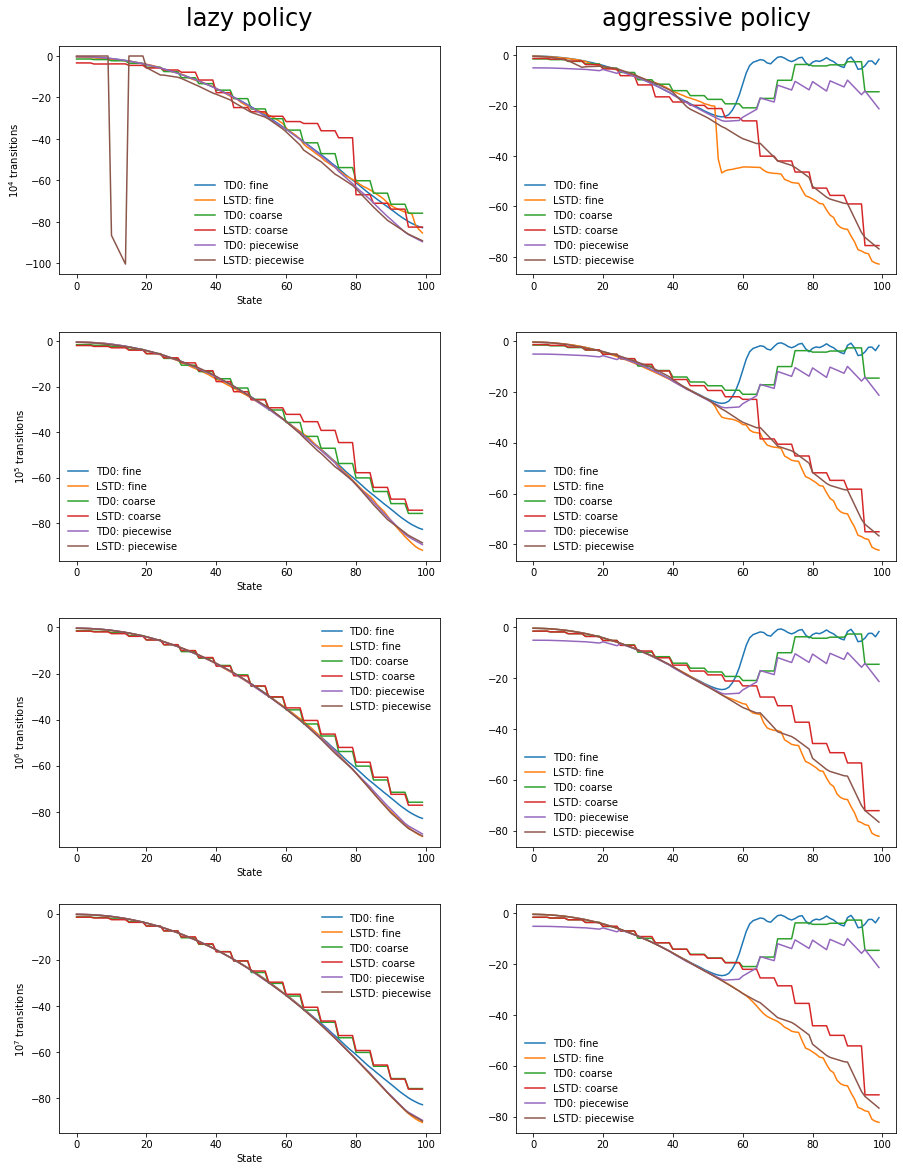

In [116]:
fig, ax = plt.subplots(4, 2, figsize=(15, 20))

policies = ['lazy', 'aggressive']
cols = [f'{i} policy' for i in policies]
rows = [f'${i}$ transitions' for i in ['10^4', '10^5', '10^6', '10^7']]

for ax_, col in zip(ax[0], cols):
    ax_.set_title(col, fontsize=24, pad=20)

for ax_, row in zip(ax[:,0], rows):
    ax_.set_ylabel(row, rotation=90)
    ax_.set_xlabel('State')
    
k = -1
for mapping_type in ['fine','coarse','piecewise']:
    k+=1
    for j, policy in enumerate(policies):
        for i, num_t in enumerate([10**4, 10**5, 10**6, 10**7]):
            for alg in ['TD0', 'LSTD']:
                xax = list(range(100))
                series = [float(feature_mapping(x, mapping_type)@results[alg][policy][mapping_type][str(num_t)]) for x in xax]
                ax[i][j].plot(xax, series, label=f'{alg}: {mapping_type}')
                ax[i][j].legend(frameon=False)
                
fig.subplots_adjust(wspace=0.2, hspace=0.25)

### 2. Some comments

The plots above compare the value functions for the two types of policies implemented (lazy and aggresive) and shows this comparisson for different numbers of transitions ($10^4, 10^5, 10^6, 10^7$). In addition, we can also observe the differences for each type of feature mapping (represented in different colors in each plot) and policy evaluation algorithm (TD0 and LSTD). We can highlight several important dynamics from the plots:

- After we reach the state with 50 people, the lazy policy and the aggresive policy diverge significant. On the one hand, the value of the subsequent states keeps decreasing for the lazy policy for both policy evaluation algorithms while in the aggresive policy this decreasing pattern is only maintained by the LSTD algorithm. The TD0 algorithm, on the other hand, completely changes the direction of the value function. A possible interpreation of this result is that given that in the aggresive policy we change to a high serving rate after reaching 50 people, the TD0 algorithm might give a high value to the subsequent states given the increased chances of serving people faster than they are coming.
- The coarse feature mapping clearly makes the value function to not be smooth at all. Fine and piecewise feature mappings achieve much more smoothness
- I cannot really explain the sudden drop in value that the first plot for the lazy policy exhibits. Suddenly, for some states near 15 the LSTD algorithm with piecewise feature mapping assign very low values to these states.

## Problem 2:  Approximate policy iteration

### 0. Classes and functions definition

The code below implements the required classess.

In [117]:
class LSTD_approx:
    def __init__(self, feauture_mapping, mapping_type, map_size, gamma):
        self.gamma = gamma
        self.feature_mapping = feature_mapping
        self.mapping_type = mapping_type
        self.A = np.zeros((map_size, map_size))
        self.b = np.zeros((map_size, 1))
        
#     def Q(self, x, service_rate, V):
#         cost = 0.51 if service_rate == 'low' else 0.6
#         return self.reward_function(x, cost) + self.gamma * (1 - self.arrival_rate) * \
#             (service_rate * V[x-1]+(1 - service_rate) * V[x]) + \
#             self.gamma * self.arrival_rate * (service_rate * V[x] + (1 - service_rate) * V[x+1])
    
#     def get_new_policy(self, service_rate_low, service_rate_high, cost, V):
#         return ['low' if self.Q(x, service_rate_low, V) > self.Q(x, self.q_high, V) 
#                 else self.q_high for x in range(self.N+1)]

    def update(self, state, reward, next_state):
        state = self.feature_mapping(state, self.mapping_type)
        next_state = self.feature_mapping(next_state, self.mapping_type)
        self.A += state.reshape(-1, 1)@(state - self.gamma*next_state).reshape(-1, 1).T
        self.b += reward * state.reshape(-1, 1)
        
    def get_V(self):
        return np.linalg.inv(self.A+np.diag([0.00001 for _ in range(len(self.b))]))@self.b

In [118]:
def Q(queue, policy, state, service_rate, gamma, V):
    cost = queue.cost[action]
    sr = queue.service_rate[action]
    return queue.reward_function(state, cost) + gamma * (1 - queue.arrival_rate) * \
        (sr * V[state-1]+(1 - sr) * V[state]) + \
        gamma * queue.arrival_rate * (sr * V[state] + (1 - sr) * V[state+1])

def get_new_policy(queue, policy, gamma, V):
    return ['low' if Q(queue, policy, x, queue.service_rate['low'], gamma, V) > Q(queue, policy, x, queue.service_rate['high'], gamma, V) 
            else 'high' for x in range(queue.N +1)]

### 1. Experiments

In [140]:
# store results
results2 = {}

# define parameters
a = 5*10**4
b = 10**5
p = 0.5
gamma = .99
queue_size = 100
state = 100
iterations = 100

actions = ['low','high']

for mapping_type, mapping_dim in zip(['fine','coarse','piecewise'], [101,20,40],):
    
    results2[mapping_type] = {'value': [], 'policy': []}
    Q_val = np.zeros([101,2])
    
    for k in range(iterations):
        queue = Queue(queue_size)
        lstd = LSTD_approx(feature_mapping, mapping_type, mapping_dim, gamma)
        A = np.zeros((mapping_dim, mapping_dim))
        B = np.zeros((mapping_dim, 1))
        
        
        policy = np.argmax(Q_val, axis=1)
        
        for transition in range(1,10**5+1):
            
            # 1. get the action from the choosen policy
            action = actions[policy[state]]
            # 2. interact with the environment to generate rewards and the next state
            reward, next_state = queue.interact(action)
            lstd.update(state, reward, next_state)
            state = next_state

                
        # calculate value
        print("***** Calculating Q value for iteration:", k, "**********")
        V = lstd.get_V()
        #print(V)
        V = [float(feature_mapping(x, mapping_type)@V) for x in range(101)]
        
        
        for x in range(101):
            for ida,a in enumerate(actions):

                Q_val[x,ida] = queue.reward_function(x,queue.service_rate[a]) + \
                                gamma*p*(queue.service_rate[a]*V[max(x-1,0)]+(1-queue.service_rate[a])*V[x]) + \
                                gamma*(1-p)*(queue.service_rate[a]*V[x]+(1-queue.service_rate[a])*V[min(x+1,100)])
        
        
        
        # save results
        results2[mapping_type]['value'].append(V)
        results2[mapping_type]['policy'].append(policy)

***** Calculating Q value for iteration: 0 **********
***** Calculating Q value for iteration: 1 **********
***** Calculating Q value for iteration: 2 **********
***** Calculating Q value for iteration: 3 **********
***** Calculating Q value for iteration: 4 **********
***** Calculating Q value for iteration: 5 **********
***** Calculating Q value for iteration: 6 **********
***** Calculating Q value for iteration: 7 **********
***** Calculating Q value for iteration: 8 **********
***** Calculating Q value for iteration: 9 **********
***** Calculating Q value for iteration: 10 **********
***** Calculating Q value for iteration: 11 **********
***** Calculating Q value for iteration: 12 **********
***** Calculating Q value for iteration: 13 **********
***** Calculating Q value for iteration: 14 **********
***** Calculating Q value for iteration: 15 **********
***** Calculating Q value for iteration: 16 **********
***** Calculating Q value for iteration: 17 **********
***** Calculating Q 

***** Calculating Q value for iteration: 50 **********
***** Calculating Q value for iteration: 51 **********
***** Calculating Q value for iteration: 52 **********
***** Calculating Q value for iteration: 53 **********
***** Calculating Q value for iteration: 54 **********
***** Calculating Q value for iteration: 55 **********
***** Calculating Q value for iteration: 56 **********
***** Calculating Q value for iteration: 57 **********
***** Calculating Q value for iteration: 58 **********
***** Calculating Q value for iteration: 59 **********
***** Calculating Q value for iteration: 60 **********
***** Calculating Q value for iteration: 61 **********
***** Calculating Q value for iteration: 62 **********
***** Calculating Q value for iteration: 63 **********
***** Calculating Q value for iteration: 64 **********
***** Calculating Q value for iteration: 65 **********
***** Calculating Q value for iteration: 66 **********
***** Calculating Q value for iteration: 67 **********
***** Calc

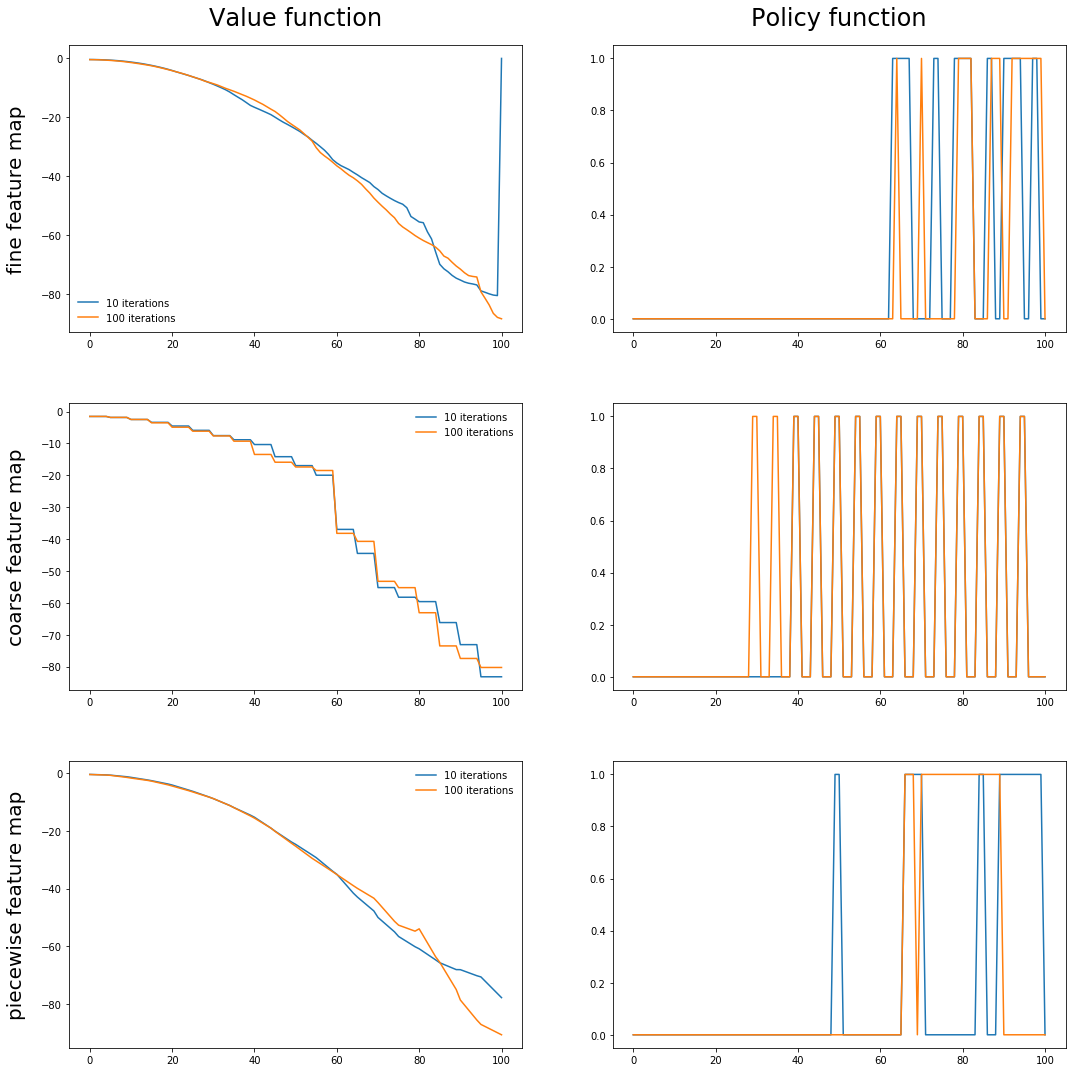

In [152]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
feat_maps = ['fine', 'coarse', 'piecewise']
rows = [f'{i} feature map' for i in feat_maps]
cols = ['Value function', 'Policy function']

for ax_, col in zip(ax[0], cols):
    ax_.set_title(col, fontsize=24, pad=20)

for ax_, row in zip(ax[:,0], rows):
    ax_.set_ylabel(row, rotation=90, size='large', fontsize=20, labelpad=15)

for i, feat_map in enumerate(feat_maps):
    phi = results2[feat_map]
    for j, func_type in enumerate(['value', 'policy']):
        ax[i][j].plot(phi[func_type][10], label='10 iterations')
        ax[i][j].plot(phi[func_type][99], label='100 iterations')
        if j == 0:
            ax[i][j].legend(frameon=False)
                
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.25)

### 2. Some comments

The plots above show both the value function and the policy function for both 10 (blue) and 100 (orange) iterations. Although the policies that we are choosing seem to be different to the lazy policy we were using before, the value function resembles closely. This seems to imply that through the proposed policy evaluation and updating process we are not able to robustly improve our initial policy. We change our policy but the changes we are making do not seem to really be making it better. A lazy policy seems to produce almost the same value function. This is true for all feature mappings.